Neurons: 39209
Label balance: 0.5338983050847458
Non-zero coefficients: 62


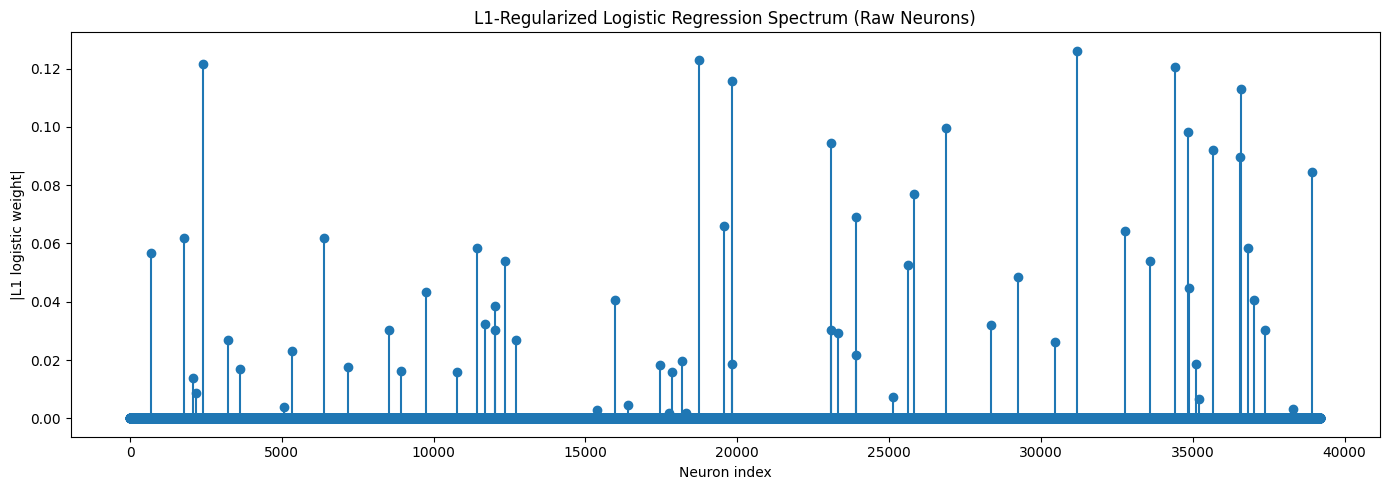

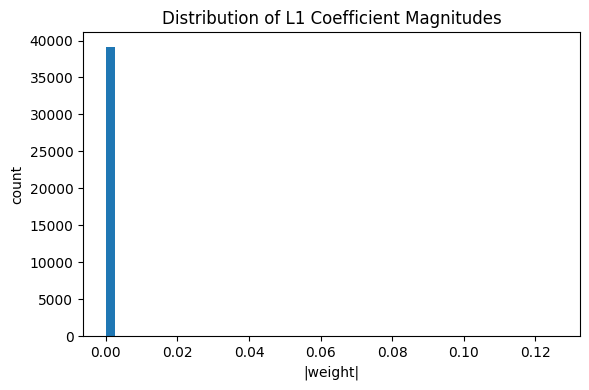

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# 1. Load data
# ---------------------------------------------------------

VIT_PATH    = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'

vit   = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']  # array shape: (118, 1000)
R     = np.load(NEURAL_PATH).T                                    # shape: (118, n_neurons)
areas = np.load(AREAS_PATH, allow_pickle=True)

n_images, n_neurons = R.shape
print("Neurons:", n_neurons)

# ---------------------------------------------------------
# 2. Construct binary animate/inanimate labels
# ---------------------------------------------------------
# Animate classes are approximately first 497 ImageNet classes.

# For each image, predicted class = argmax(logits)
predicted_classes = np.argmax(vit, axis=1)

y = (predicted_classes < 397).astype(int)   # 1 = animate, 0 = inanimate
print("Label balance:", np.mean(y))

# ---------------------------------------------------------
# 3. Standardize neural responses
# ---------------------------------------------------------
scaler = StandardScaler()
R_std = scaler.fit_transform(R)

# ---------------------------------------------------------
# 4. Fit L1 logistic regression
# ---------------------------------------------------------
clf = LogisticRegression(
    penalty='l1',
    solver='saga',          # supports L1 for high dimensions
    C=0.1,                  # stronger regularization → cleaner sparsity
    max_iter=5000,
    tol=1e-4
)

clf.fit(R_std, y)

beta = clf.coef_.ravel()   # shape (n_neurons,)

print("Non-zero coefficients:", np.sum(beta != 0))

# ---------------------------------------------------------
# 5. Plot comb spectrum
# ---------------------------------------------------------

plt.figure(figsize=(14, 5))
plt.stem(np.abs(beta), basefmt=" ")
plt.xlabel("Neuron index")
plt.ylabel("|L1 logistic weight|")
plt.title("L1-Regularized Logistic Regression Spectrum (Raw Neurons)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 6. Plot histogram of coefficient magnitudes (sparsity)
# ---------------------------------------------------------

plt.figure(figsize=(6, 4))
plt.hist(np.abs(beta), bins=50)
plt.xlabel("|weight|")
plt.ylabel("count")
plt.title("Distribution of L1 Coefficient Magnitudes")
plt.tight_layout()
plt.show()



--- Fold 1 ---


/home/maria/global_venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Non-zero neurons: 50
Accuracy: 0.75

--- Fold 2 ---
Non-zero neurons: 54
Accuracy: 0.75

--- Fold 3 ---
Non-zero neurons: 54
Accuracy: 0.5833333333333334

--- Fold 4 ---
Non-zero neurons: 59
Accuracy: 0.6086956521739131

--- Fold 5 ---
Non-zero neurons: 44
Accuracy: 0.8260869565217391

=== Cross-validation summary ===
Mean accuracy: 0.7036231884057972
Accuracy std: 0.09249851693606076
Mean non-zero neurons: 52.2


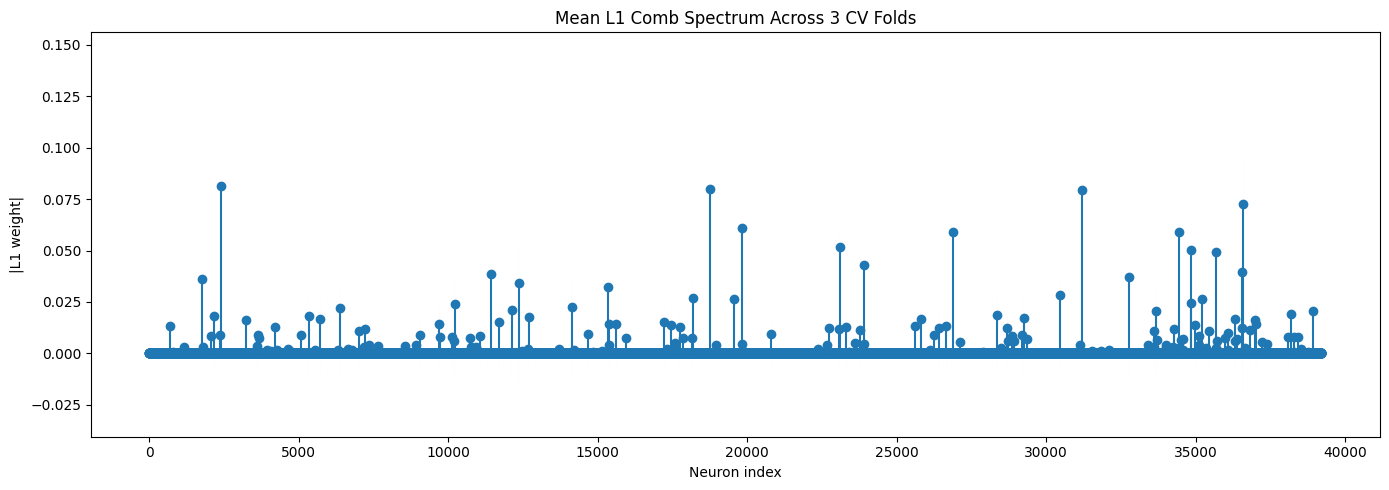

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# ---------------------------------------------------------
# 1. Load data
# ---------------------------------------------------------

VIT_PATH    = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'

vit   = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R     = np.load(NEURAL_PATH).T
areas = np.load(AREAS_PATH, allow_pickle=True)

# ---------------------------------------------------------
# 2. Animate / inanimate labels
# ---------------------------------------------------------

predicted_classes = np.argmax(vit, axis=1)
y = (predicted_classes < 397).astype(int)

# ---------------------------------------------------------
# 3. Cross-validation setup
# ---------------------------------------------------------

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

betas = []
accuracies = []
nonzero_counts = []

# ---------------------------------------------------------
# 4. Cross-validation loop
# ---------------------------------------------------------

for fold, (train_idx, test_idx) in enumerate(kf.split(R, y)):
    print(f"\n--- Fold {fold + 1} ---")

    # Split data
    R_train, R_test = R[train_idx], R[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Standardize (fit ONLY on training data)
    scaler = StandardScaler()
    R_train_std = scaler.fit_transform(R_train)
    R_test_std  = scaler.transform(R_test)

    # L1 Logistic Regression
    clf = LogisticRegression(
        penalty='l1',
        solver='saga',
        C=0.1,
        max_iter=5000,
        tol=1e-4
    )

    clf.fit(R_train_std, y_train)

    # Store weights
    beta = clf.coef_.ravel()
    betas.append(beta)

    # Sparsity
    nonzero = np.sum(beta != 0)
    nonzero_counts.append(nonzero)
    print("Non-zero neurons:", nonzero)

    # Accuracy
    y_pred = clf.predict(R_test_std)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print("Accuracy:", acc)

betas = np.array(betas)

# ---------------------------------------------------------
# 5. Summary statistics
# ---------------------------------------------------------

print("\n=== Cross-validation summary ===")
print("Mean accuracy:", np.mean(accuracies))
print("Accuracy std:", np.std(accuracies))
print("Mean non-zero neurons:", np.mean(nonzero_counts))

# ---------------------------------------------------------
# 6. Mean comb spectrum across folds
# ---------------------------------------------------------

mean_spectrum = np.mean(np.abs(betas), axis=0)
std_spectrum  = np.std(np.abs(betas), axis=0)

plt.figure(figsize=(14, 5))
plt.stem(mean_spectrum, basefmt=" ")
plt.fill_between(
    np.arange(len(mean_spectrum)),
    mean_spectrum - std_spectrum,
    mean_spectrum + std_spectrum,
    alpha=0.2
)
plt.xlabel("Neuron index")
plt.ylabel("|L1 weight|")
plt.title("Mean L1 Comb Spectrum Across 3 CV Folds")
plt.tight_layout()
plt.show()
